In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [3]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test

In [75]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions

In [4]:
from sksurv.datasets import get_x_y
from sksurv.metrics import integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

In [33]:
FIG_SIZE = (20, 10)
plt.rcParams.update({'figure.figsize': FIG_SIZE})   

In [36]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [37]:
df['churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [38]:
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], df['churn'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

Text(0.5, 1.0, 'Kaplan-Meier Curve')

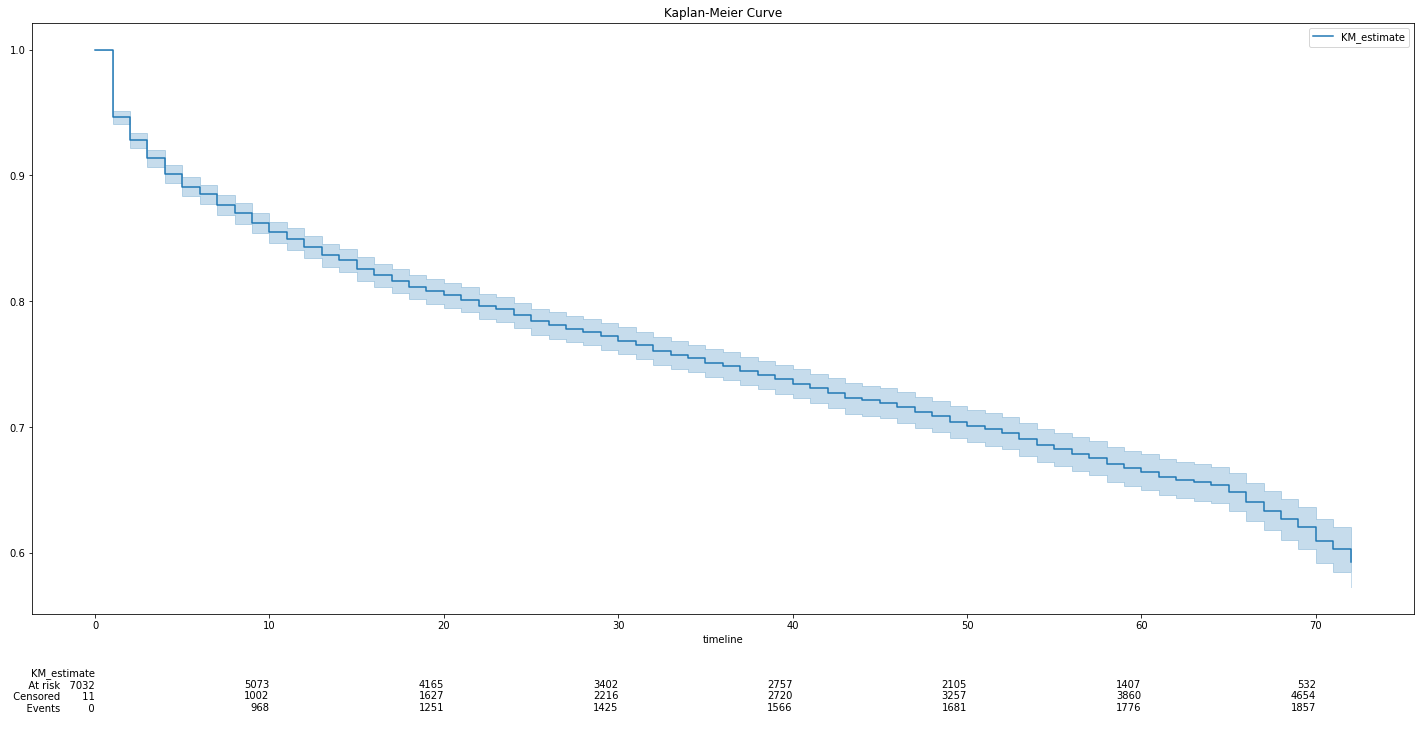

In [39]:
kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve')

In [40]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

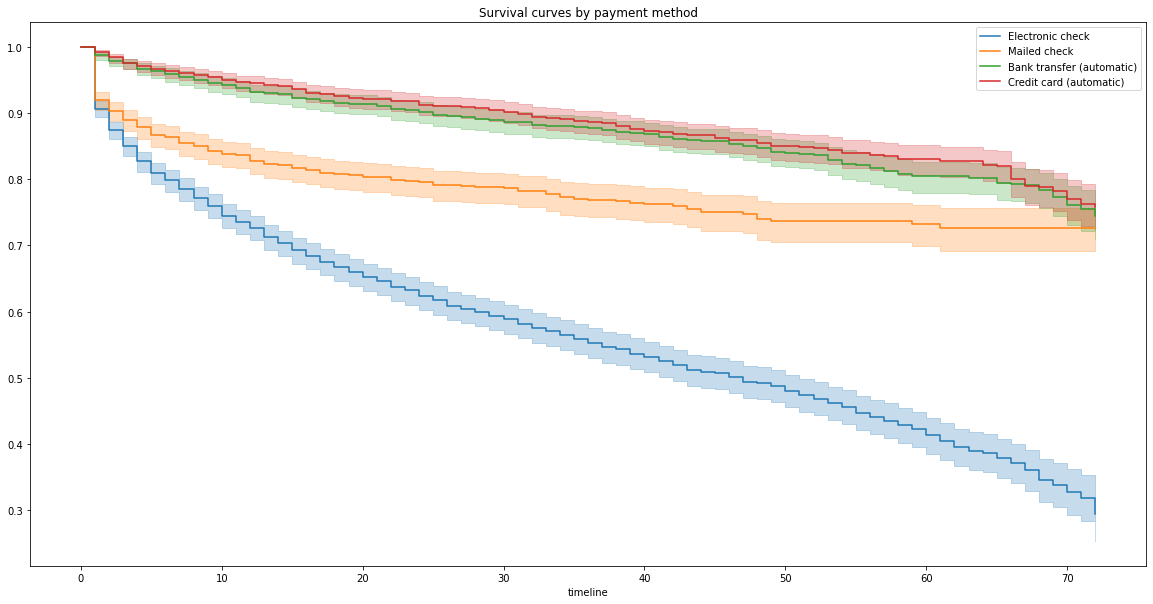

In [41]:
ax = plt.subplot()

for method in df['PaymentMethod'].unique():
    condition = df['PaymentMethod'] == method
    
    kmf = KaplanMeierFitter()
    kmf.fit(df.loc[condition, 'tenure'], df.loc[condition, 'churn'], label=method)
    kmf.plot(ax=ax)
    
plt.title("Survival curves by payment method");

In [42]:
credit_card = df['PaymentMethod'] == 'Credit card (automatic)'
bank_transfer = df['PaymentMethod'] == 'Bank transfer (automatic)'

In [43]:
results = logrank_test(df.loc[credit_card, 'tenure'],
                       df.loc[bank_transfer, 'tenure'],
                       df.loc[credit_card, 'churn'],
                       df.loc[bank_transfer, 'churn'])

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

In [44]:
results = pairwise_logrank_test(df['tenure'], df['PaymentMethod'], df['churn'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

Text(0.5, 1.0, 'Cumulative hazard function')

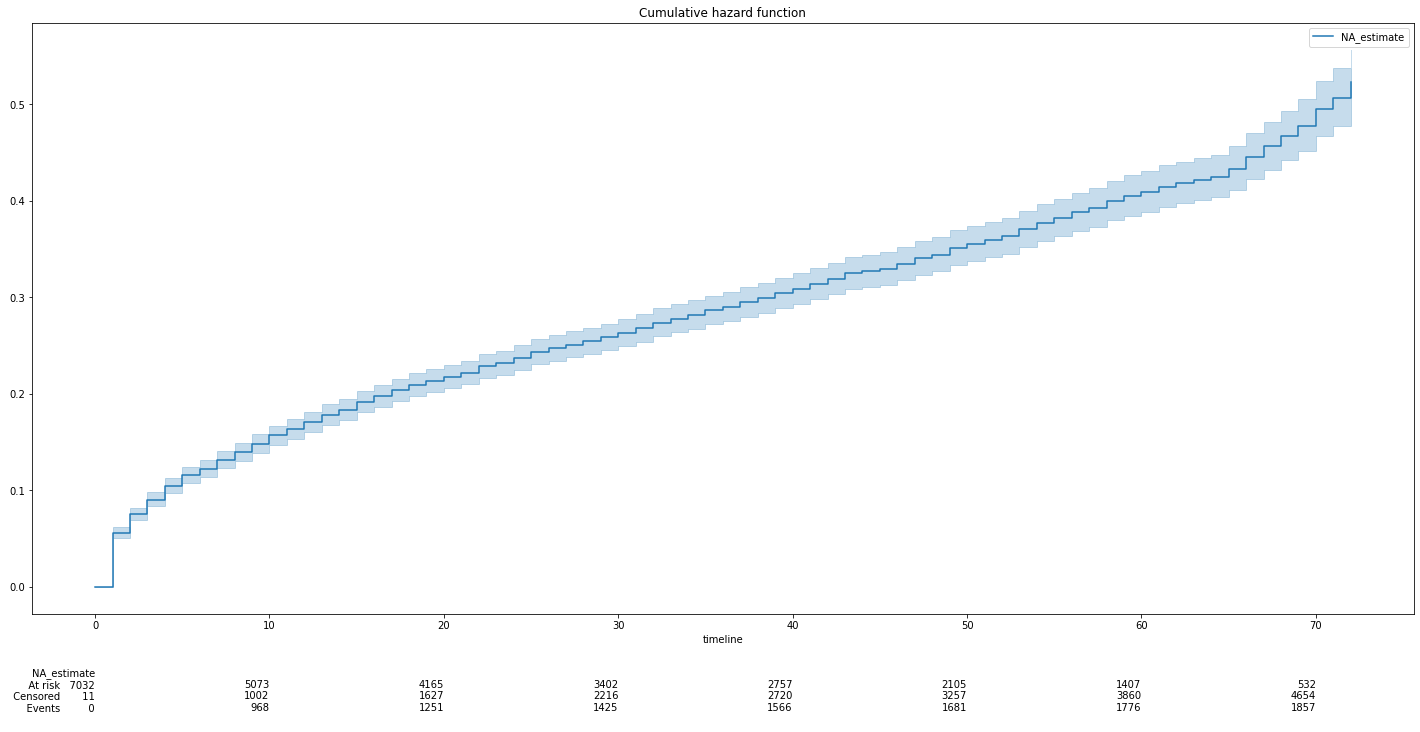

In [45]:
naf = NelsonAalenFitter()
naf.fit(df['tenure'], df['churn'])

naf.plot(at_risk_counts=True)
plt.title('Cumulative hazard function')

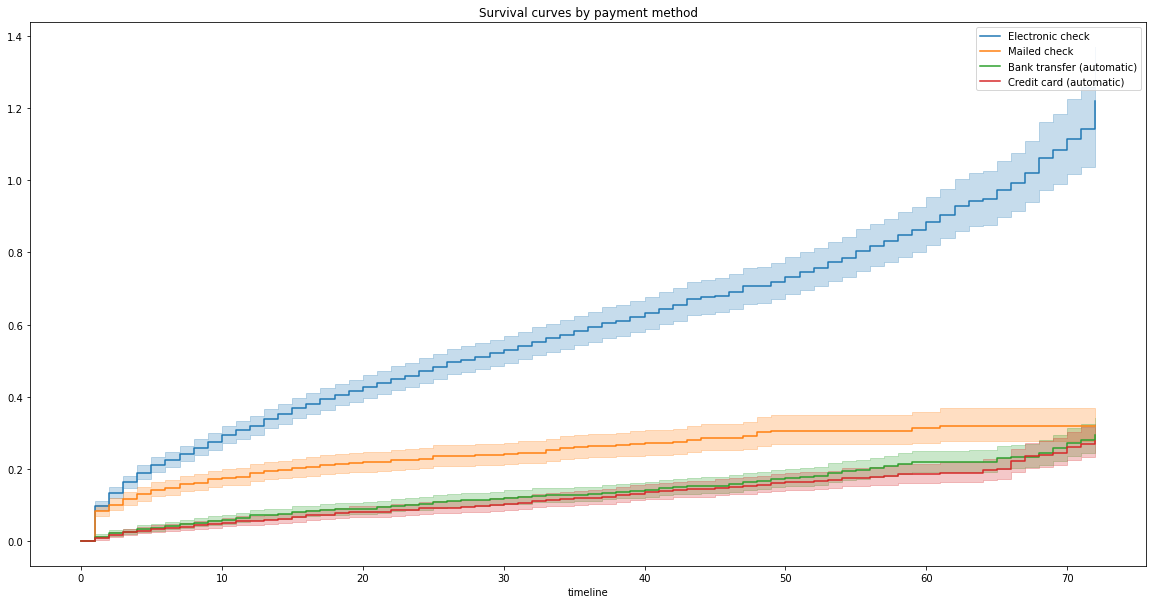

In [46]:
ax = plt.subplot()

for method in df['PaymentMethod'].unique():
    condition = df['PaymentMethod'] == method
    
    naf = NelsonAalenFitter()
    naf.fit(df.loc[condition, 'tenure'], df.loc[condition, 'churn'], label=method)
    naf.plot(ax=ax)
    
plt.title("Survival curves by payment method");

In [47]:
df = pd.get_dummies(df.loc[:, ['gender', 'SeniorCitizen', 'Partner','tenure', 'churn', 'PhoneService', 'OnlineSecurity', 'Contract']], drop_first=True)
df_train, df_test =  df.iloc[:-10], df.iloc[-10:]

In [48]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col='tenure', event_col='churn')

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>

In [49]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7033
number of events observed = 1867
   partial log-likelihood = -14141.867
         time fit was run = 2022-07-27 20:40:31 UTC

---
                                     coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       z       p
covariate                                                                                                     
SeniorCitizen                      -0.034      0.966                0.869                1.075  -0.633   0.527
gender_Male                        -0.056      0.945                0.863                1.035  -1.218   0.223
Partner_Yes                        -0.615      0.541                0.490                0.596 -12.341 <0.0005
PhoneService_Yes                    0.169      1.184                1.011                1.388   2.092   0.036
OnlineSecurity_No internet service -0.747      0.474                0.389                0.577  -7.411 <0.0005
OnlineSecurity_Yes                 -0.786      0.456                0.401                0.518 -12.026 <0.0005
Contract_One year                  -1.966      0.140                0.118                0.165 -23.072 <0.0005
Contract_Two year                  -3.774      0.023                0.017                0.031 -23.470 <0.0005
---
Concordance = 0.829
Partial AIC = 28299.733
log-likelihood ratio test = 2985.035 on 8 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

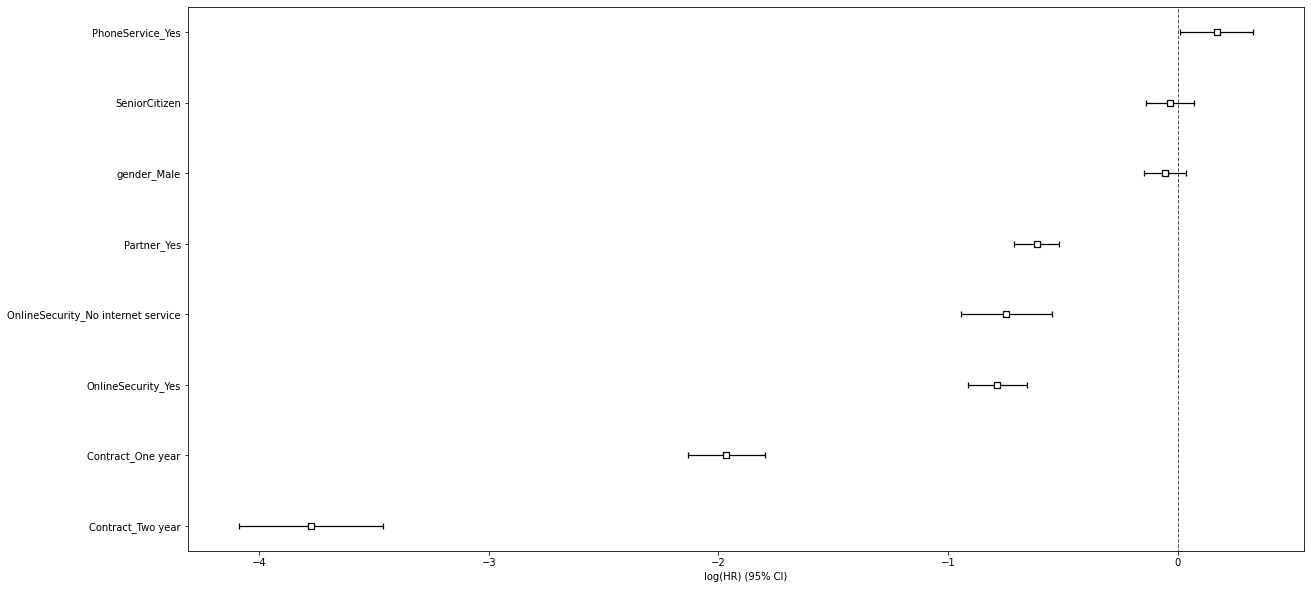

In [50]:
cph.plot()

In [51]:
forecast = cph.predict_survival_function(df_test)

<AxesSubplot:>

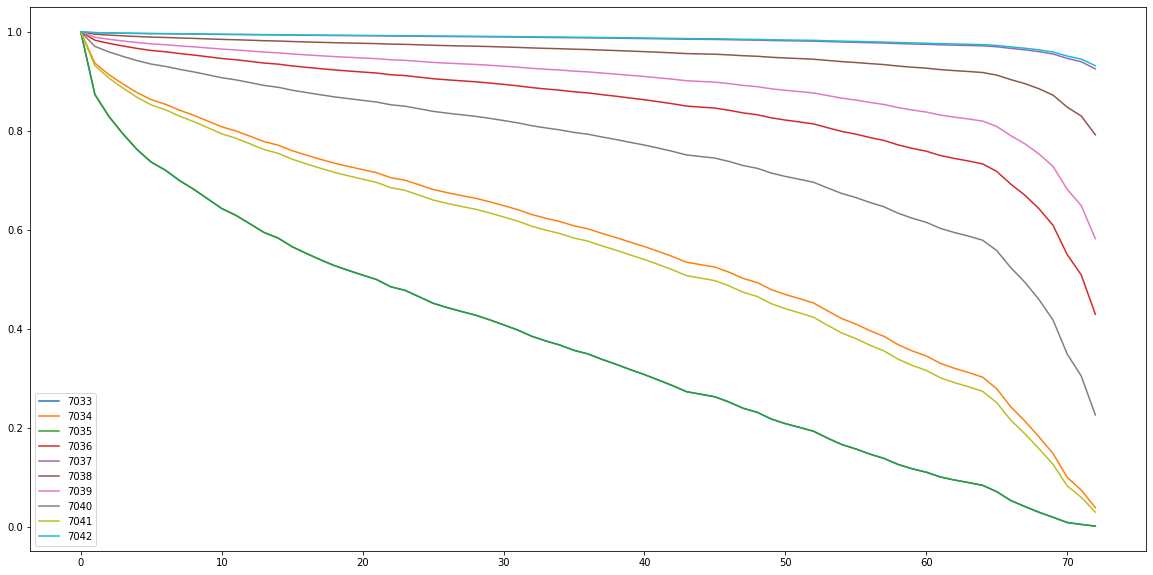

In [52]:
forecast.plot()

<AxesSubplot:>

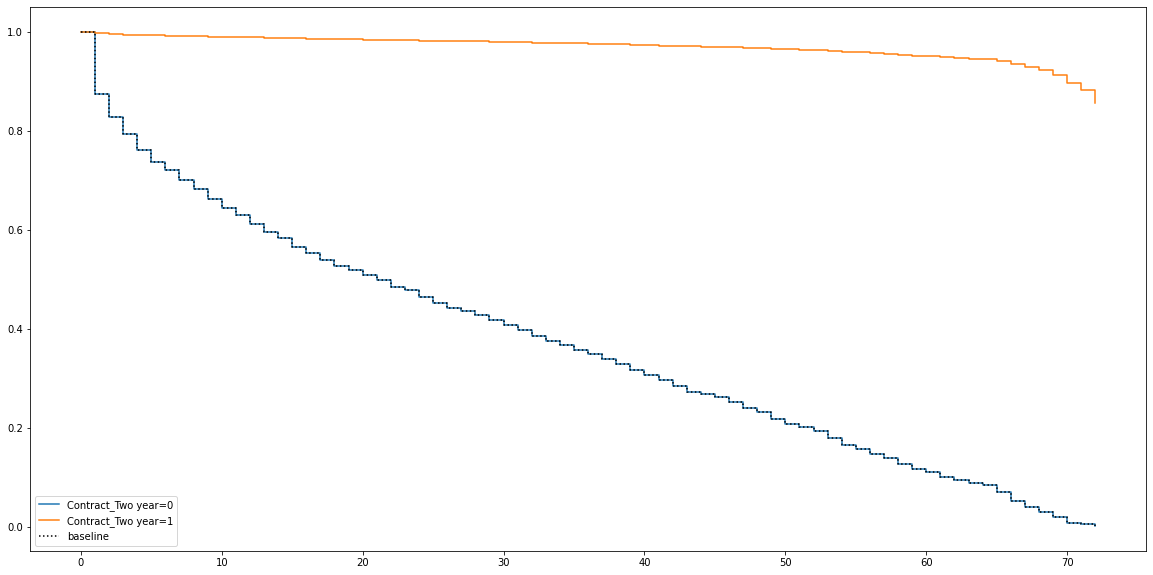

In [53]:
cph.plot_partial_effects_on_outcome('Contract_Two year', values=[0, 1])

In [54]:
x_train, y_train = get_x_y(df_train, ['churn', 'tenure'], pos_label=1)
x_test, y_test = get_x_y(df_test, ['churn', 'tenure'], pos_label=1)

In [55]:
est = RandomSurvivalForest()
est.fit(x_train, y_train)

RandomSurvivalForest()

In [56]:
est.score(x_test, y_test)

0.8181818181818182

In [57]:
times = np.arange(pd.DataFrame(y_test).iloc[:, 1].min(), pd.DataFrame(y_test).iloc[:, 1].max())
preds = np.array([[fn(t) for t in times] for fn in est.predict_survival_function(x_test)])

integrated_brier_score(y_train, y_test, 
                       preds,
                       times
                      )

0.11520585388933943

In [58]:
est = GradientBoostingSurvivalAnalysis()
est.fit(x_train, y_train)

GradientBoostingSurvivalAnalysis()

In [59]:
est.score(x_test, y_test)

0.8181818181818182

In [60]:
times = np.arange(pd.DataFrame(y_test).iloc[:, 1].min(), pd.DataFrame(y_test).iloc[:, 1].max())
preds = np.array([[fn(t) for t in times] for fn in est.predict_survival_function(x_test)])

integrated_brier_score(y_train, y_test, 
                       preds,
                       times
                      )

0.10842132943998346

In [62]:
df = pd.read_csv('data/historical_transactions.csv', nrows=500000, usecols=['card_id', 'purchase_date', 'purchase_amount'], parse_dates=['purchase_date'])

In [64]:
skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 500000 │ │ object      │ 1     │                                    │
│ │ Number of columns │ 3      │ │ float64     │ 1     │                                    │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃           ┃ missing ┃ complete ┃ mean  ┃ sd ┃ p0    ┃ p25   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┃           ┃         ┃ rate     ┃       ┃    ┃       ┃       ┃       ┃       ┃        ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ purchase_ │       0 │        1 │ -0.41 │ 45 │ -0.75 │ -0.72 │ -0.62 │ 20000 │   █    │  │
│ │ amount    │         │          │       │    │       │       │       │       │        │  │
│ └───────────┴─────────┴──────────┴───────┴────┴───────┴───────┴───────┴───────┴────────┘  │
│                                         datetime                                          │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃               ┃ missing ┃ complete rate ┃ first         ┃ last           ┃ frequency ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ purchase_date │       0 │             1 │  2017-01-01   │   2018-02-28   │ None      │  │
│ │               │         │               │   00:46:31    │    23:43:23    │           │  │
│ └───────────────┴─────────┴───────────────┴───────────────┴────────────────┴───────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

In [66]:
rfm = summary_data_from_transaction_data(df, customer_id_col='card_id', datetime_col='purchase_date', monetary_value_col='purchase_amount', freq='D')

In [67]:
rfm.head()

frequency  recency      T  monetary_value
card_id                                                   
C_ID_002198cdf1       51.0    176.0  195.0       -1.189117
C_ID_0032aebb26      150.0    241.0  242.0       -1.659501
C_ID_003839dd44      159.0    403.0  408.0       -0.940783
C_ID_0046db9f8a      102.0    397.0  397.0       -0.604811
C_ID_00727b1b66       10.0    125.0  136.0       -0.384135

In [68]:
skim(rfm)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 2400   │ │ float64     │ 4     │                                    │
│ │ Number of columns │ 4      │ └─────────────┴───────┘                                    │
│ └───────────────────┴────────┘                                                            │
│                                          number                                           │
│ ┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃           ┃ missing ┃ complete   ┃ mean  ┃ sd  ┃ p0   ┃ p25  ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┃           ┃         ┃ rate       ┃       ┃     ┃      ┃      ┃       ┃      ┃        ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ frequency │       0 │          1 │   100 │  72 │    3 │   47 │   140 │  380 │ █▆▃▂▁  │  │
│ │ recency   │       0 │          1 │   300 │ 110 │   43 │  200 │   410 │  420 │ ▁▂▃▂▂█ │  │
│ │ T         │       0 │          1 │   330 │ 110 │   59 │  240 │   420 │  420 │ ▁▂▁▁▁█ │  │
│ │ monetary_ │       0 │          1 │ -0.85 │ 3.6 │ -3.1 │ -1.3 │ -0.88 │   91 │   █    │  │
│ │ value     │         │            │       │     │      │      │       │      │        │  │
│ └───────────┴─────────┴────────────┴───────┴─────┴──────┴──────┴───────┴──────┴────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

In [71]:
rfm_cal_holdout = calibration_and_holdout_data(df, customer_id_col='card_id', datetime_col='purchase_date', monetary_value_col='purchase_amount', freq='D', 
                                               calibration_period_end='2017-12-31', observation_period_end='2018-02-28')

In [72]:
rfm_cal_holdout

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
card_id                                                                  
C_ID_002198cdf1           32.0        135.0  136.0           -1.165039   
C_ID_0032aebb26          111.0        173.0  183.0           -1.571031   
C_ID_003839dd44          135.0        348.0  349.0           -0.912989   
C_ID_0046db9f8a           82.0        333.0  338.0           -0.609449   
C_ID_00727b1b66            7.0         70.0   77.0           -0.540849   
...                        ...          ...    ...                 ...   
C_ID_ff81e7167b          208.0        337.0  340.0           -1.761969   
C_ID_ff8c27534c           64.0        251.0  362.0           -1.474925   
C_ID_ffaced5b31           42.0        187.0  188.0           -0.903391   
C_ID_ffb9c6be8e           23.0        171.0  196.0           -1.032464   
C_ID_ffbe6ed0b4           49.0        351.0  353.0           -1.059633   

                 frequency_holdout  monetary_value_holdout  duration_holdout  
card_id                                                                       
C_ID_002198cdf1               19.0               -0.648992              59.0  
C_ID_0032aebb26               39.0               -0.716737              59.0  
C_ID_003839dd44               24.0               -0.692921              59.0  
C_ID_0046db9f8a               19.0               -0.379676              59.0  
C_ID_00727b1b66                3.0               -0.018468              59.0  
...                            ...                     ...               ...  
C_ID_ff81e7167b               28.0               -0.591908              59.0  
C_ID_ff8c27534c                0.0                0.000000              59.0  
C_ID_ffaced5b31               24.0               -0.485763              59.0  
C_ID_ffb9c6be8e               18.0               -0.697285              59.0  
C_ID_ffbe6ed0b4               17.0               -0.665250              59.0  

[2399 rows x 7 columns]

In [74]:
bgf = BetaGeoFitter(0.9)
bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], recency=rfm_cal_holdout['recency_cal'], T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2399 subjects, a: 0.01, alpha: 1.54, b: 0.19, r: 0.53>

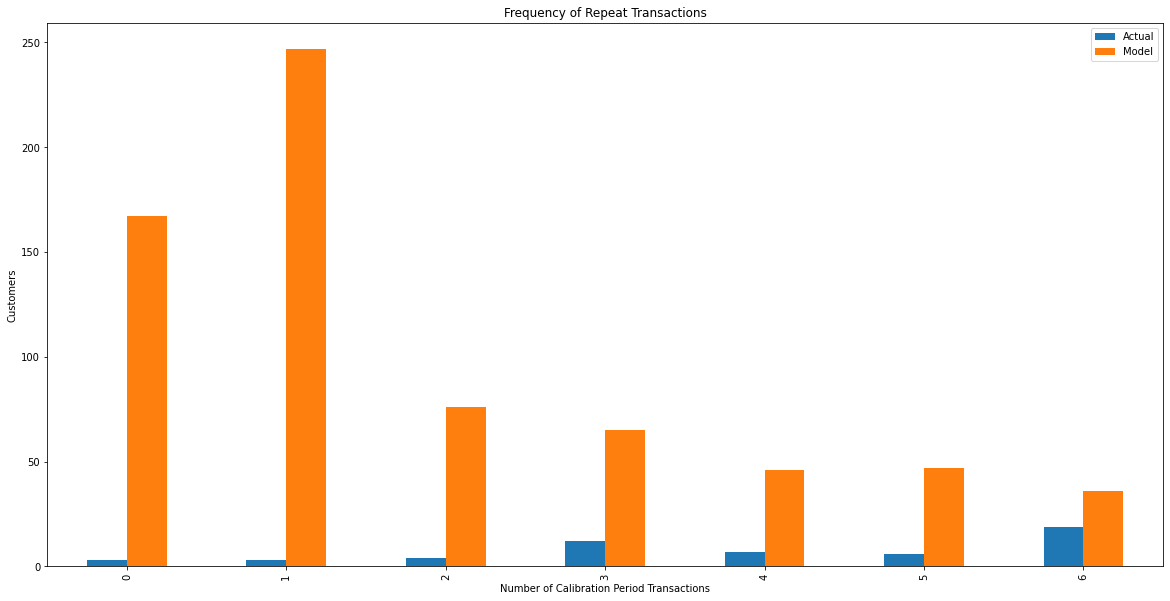

In [76]:
plot_period_transactions(bgf);

In [77]:
sample_customer = rfm_cal_holdout.iloc[13]
sample_customer

frequency_cal              68.000000
recency_cal               280.000000
T_cal                     296.000000
monetary_value_cal         -1.571509
frequency_holdout           5.000000
monetary_value_holdout     -0.729487
duration_holdout           59.000000
Name: C_ID_01b098ff01, dtype: float64

In [78]:
bgf.predict(60, frequency=sample_customer['frequency_cal'], recency=sample_customer['recency_cal'], T=sample_customer['T_cal'])

13.68081350614679